# Dimensionality reduction and noise removal of simple images using Non-negative Matrix Factorization

In these troubling times, handling data efficiently is paramount to being able to store vast amounts of information. Major companies, such as Facebook, Netflix, YouTube, etc., need to collect vast amount of data from their dousins of users for various purposes. But since they have such a huge userbase, it would be impossible to store all of the desirable statistics. We will therefore take a closer look at storing data efficiently. The method we will use is a form of dimensionality reduction. By that we mean transforming high-dimensional data, into low-dimensional data, by removing redundancies. In this project we will look at pictures, and pictures are usually of a very large size. Thus, it is appropriate to be able to store the data in a more efficient manner. Specifically, we will be using Non-negative Matrix Factorization (NMF) to achieve this. With this method, we also get image denoising for free, which is beneficial in image processing. We will also study how good NMF is for image denoising.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %pip install opencv-python # Required to import cv2 !!!
import cv2

import os
import time

%matplotlib inline


In [2]:
SEED = 0x4D6F6E6B6579  # Default seed for replicable results

## Code for loading and displaying images

In [3]:
def loadImages(N, *, folderpath='./imgs'):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded, in the same order. 
    Args:
        N, integer, number of images to load
        folderpath (str, optional): Path to the folder containing images. Defaults to './imgs'
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    imgs = np.zeros((24, 24, 4, N))

    # Iteration variable
    i = 0

    # Index of specific image with predetermined cryptopunk
    index_of_ape = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk(folderpath):

        # Iterate over files
        for filename in sorted(files):

            # Make sure that the file is a .png
            if filename.endswith('.png'):
                if filename == '5314.png':
                    index_of_ape = i

                # Filepath to load from
                filepath = os.path.join(subdir, filename)

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                imgs[:, :, :, i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255

                i += 1
            if i >= N:
                break
        if i >= N:
            break

    # Placing the special predetermined cyberpunk at the beginning
    imgs[:, :, :, 0], imgs[:, :, :, index_of_ape] = imgs[:, :, :, index_of_ape], imgs[:, :, :, 0]

    return imgs


In [4]:
def splitImages(imgs):
    # Split the images into opacity and rgb channels
    imgs_opacity = imgs[:, :, 3, :]
    imgs_rgb = imgs[:, :, :3, :]

    # Clever reshape "trick". This is the matrix we will apply the NMF to
    imgs_reshaped = imgs_rgb.reshape(-1, imgs_rgb.shape[-1])
    return imgs_reshaped, imgs_opacity, imgs_rgb


def reshapeToImage(matrix, *, withOpacity=True):
    """Reshapes the input 2D matrix to a 4D array corresponding to a set of images.

    Note: numpy.reshape with -1 as a dimension automatically infers that dimension length

    Args:
        matrix (np.ndarray): The matrix to reshape to image
        withOpacity(bool, optional): If True, reshapes to 4 channels, the last one corresponding to opacity, else 3 channels. Defaults to True.
    Returns: 
        np.ndarray: The reshaped matrix
    """
    if withOpacity:
        return matrix.reshape(24, 24, 4, -1)
    return matrix.reshape(24, 24, 3, -1)


def addOpacityChannel(imgs_rgb, imgs_opacity):
    """
    Creates a new image with the rgb values from imgs_rgb and opacity from imgs_opcaity
    
    Note: numpy.reshape with -1 as a dimension automatically infers that dimension length
    
    Args:
        imgs_rgb: (24, 24, 3, N) array[float] (or converible to (24, 24, 3, N))
        imgs_opacity: (24, 24, 1, N) array[float]
    Returns:
        (24,24,4,N) array[float]
    """
    imgs_rgb = imgs_rgb.reshape(24, 24, 3, -1)
    withOpacity = np.zeros((24, 24, 4, imgs_rgb.shape[-1]))

    withOpacity[:, :, :3, :] = imgs_rgb
    withOpacity[:, :, 3, :] = imgs_opacity
    return withOpacity



In [5]:
# Code for plotting images
def plotimgs(imgs, nplot=8, *, rescale=False, filename=None):
    """
    Plots nplot**2 images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    Args:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N >= nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """

    if nplot != 1:

        # Initialize subplots
        fig, axes = plt.subplots(nplot, nplot, figsize=(16, 16))

        # Set background color
        fig.set_facecolor("lightgray")

        # Iterate over images
        for i in range(nplot):
            for j in range(nplot):
                idx = i*nplot + j

                # Remove axis
                axes[i, j].axis('off')

                # Rescale RGB channels by dividing my maximal value
                if rescale:
                    scaled_img = imgs[:, :, :, idx].copy()
                    scaled_img[:, :, :3] /= scaled_img[:, :, :3].max()
                    axes[i, j].imshow(scaled_img)
                else:
                    axes[i, j].imshow(imgs[:, :, :, idx])

        # Tight layout so images will appear closer together
        plt.tight_layout()
    else:
        fig = plt.figure(figsize=(4, 4))
        fig.set_facecolor("lightgray")
        plt.axis('off')
        if rescale:
            scaled_img = imgs.copy()
            scaled_img[:, :, :3] /= scaled_img[:, :, :3].max()
            plt.imshow(scaled_img)
        else:
            plt.imshow(imgs)
    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()


### Code for adding random noise

In [6]:
def add_noise(imgsArray, *, sigma=0.1, seed=SEED):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Args:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    
    imgs_reshaped, imgs_opacity, imgs_rgb = imgsArray

    # Array that will store the rgb channels of the noisy images
    noisy_imgs = imgs_reshaped.copy()

    # Number of noisy values we need
    nnzero = np.count_nonzero(imgs_reshaped)

    # Sample noisy values and add noise
    noise = np.random.default_rng(seed).normal(0, 1, nnzero)
    noisy_imgs[imgs_reshaped != 0] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_imgs = noisy_imgs.clip(0, 1)

    return noisy_imgs


def imgsNoise(noisy_imgs, imgs, imgsArray):
    imgs_reshaped, imgs_opacity, imgs_rgb = imgsArray

    # Calculate the error of the noisy images
    noise_residual = np.linalg.norm(noisy_imgs - imgs_reshaped, 'fro')

    # For plotting noisy images we add the opacity
    noisy_imgs_with_opacity = np.zeros_like(imgs)
    noisy_imgs_with_opacity[:, :, :3, :] = noisy_imgs.reshape(imgs_rgb.shape)
    noisy_imgs_with_opacity[:, :, 3, :] = imgs_opacity
    plotimgs(noisy_imgs_with_opacity)


In [7]:
def chooseNImages(N=500, *, seed=SEED):
    """
    Chooses n images randomly
    Args:
        N: int
        seed: int
    Returns:
        imgs: (24,24,4,N) array[float]
    
    """

    # Load all 10000 images
    imgs = loadImages(10000)

    # Select N random images
    choices = np.random.default_rng(seed).choice(imgs.shape[-1], N, replace=False)

    # Always keeping the 0th image as 0
    zero_indexes, = np.where(choices == 0)
    if zero_indexes.size > 0:
        choices[0], choices[zero_indexes[0]] = choices[zero_indexes[0]], choices[0]
    else:
        choices[0] = 0
    
    imgs = imgs[:, :, :, choices]

    # Check that the shape is correct
    assert imgs.shape == (24, 24, 4, N), "Array shape is not correct"
    return imgs


### Declaring global constants

In [8]:
# Global Constants

A1 = np.array([[1, 0],
               [0, 1]])

A2 = np.array([[1, 2],
               [1, 1],
               [1, 2]])

A3 = np.array([[2, 1, 1],
               [2, 1, 1],
               [1, 1, 2]])

A4 = np.array([[2, 1, 0],
               [1, 2, 3],
               [0, 3, 3]])


IMGS = chooseNImages()

IMGS_RESHAPED, IMGS_OPACITY, IMGS_RGB = splitImages(IMGS)
IMGS_NOISY_05 =  add_noise((IMGS_RESHAPED, IMGS_OPACITY, IMGS_RGB), sigma=0.05) # adding noise with scalar noise level 0.05
IMGS_NOISY_1 = add_noise((IMGS_RESHAPED, IMGS_OPACITY, IMGS_RGB), sigma=0.1) # adding noise with scalar noise level 0.1
IMGS_NOISY_2 = add_noise((IMGS_RESHAPED, IMGS_OPACITY, IMGS_RGB), sigma=0.2) # adding noise with scalar noise level 0.2


## Task 1

We will present the NMF algorithm before we discuss using it for dimensionality reduction.

NMF is based on the asumption that we may write:

$$ A \approx A_{NMF} = WH $$

We start by presenting the algorithm to calculate an NMF, and some notation. The algorithm we will be using is a multiplicative update rule proposed by Lee and Seung. The algorithm updates W and H as following:

$ (H_{k+1})_{ij} = (H_k)_{ij} \dfrac{(W_k^T A)_{ij}}{(W_k^TW_kH_k)_{ij}} $

$ (W_{k+1})_{ij} = (W_k)_{ij} \dfrac{(AH_{k+1}^T)_{ij}}{(W_kH_{k+1}H_{k+1}^T)_{ij}} $

We will be using the operators $\odot$ and $\oslash$, which are defined as:

$ (A \odot B)_{ij} = A_{ij} \cdot B_{ij} $,

$ (A \oslash B)_{ij} = \frac{A_{ij}}{B_{ij}} $

Before we go further in our discussion, we want to study certain properties of our matrices. These properties are of important importance in the algorithms we intend to use further in the project.

### a) 

It is crucial to NMF that the matrices we use are non-negative. We first want to show that this implies that $W_k, H_k$ are non-negative for $\forall k \geq 0$.

Let $A$ be a non-negative $n_H \times m_W$ matrix, and let $W_0, H_0$ be positive $n_W \times m_W$, and $n_H \times m_H$ matrices respectively.

We will prove this using induction. We will first make use of an induction hypothesis, namely that $W_t, H_t$ are positive. Then choose $r_H, c_H, r_W, c_W$, such that:

$1 \leq r_H \leq n_H,$ 

$1 \leq c_H \leq m_H$,

$1 \leq r_W \leq n_W$,

$1 \leq c_W \leq m_W$

$H_k$ for $k = t + 1$:

$(H_{t+1})_{r_H c_H} = (H_t)_{r_H c_H} \dfrac{(W_t^TA)_{r_H c_H}}{(W_t^TW_tH_t)_{r_H c_H}}$

From the assumption we have that every element in $H_t, W_t$ and $A$ are non negative, so it follows that matrix multiplication with these matrices may only net matrices with non-negative elements. In particular we have that $(H_{t+1})_{r_H c_H} = \prod a_i$, where $a_i$ is non-negative for every $i$ $\implies (H_{t+1})_{r_H c_H} \geq 0$. In fact, since $r_H$ and $c_H$ were arbitrarily chosen, we have that $H_{t+1}$ is non-negative.

$W_k$ for $k = t + 1$:

$(W_{t+1})_{r_W c_W} = (W_t)_{r_W c_W} \dfrac{(AH_{t+1}^T)_{r_W c_W}}{(W_tH_{t+1}H_{t+1}^T)_{r_W c_W}}$

Similarly, since we found that $H_{t+1}$ is non-neagtive, we have that $(W_{t+1})_{r_W c_W} \geq 0$. And since $r_W$ and $c_W$ were arbitrarily chosen, we have that $W_{t+1}$ is non-negative.

Now since $W_0, H_0$ were positve, and thus non-negative, we have successfully proven by induction that $W_k, H_k$ are non-negative for $\forall k \geq 0.$ $\blacksquare$

### b) 

Our algorithm has the opportunity to end up in a fixed point, that is, $H_{k+1} = H_{k}$. We now want to take a closer look at this property.

Let $(W_k^TA) \oslash (W_k^TW_kH_k) = \overline{1}$, where $\overline{1}_{ij} = 1$ for $\forall i,j$. We want to prove that this happens when $A = WH$, and that this implies that $H_{k+1} = H_{k}$.

Inserting $A = WH$ gives that: $W^TA = W^TWH$ so clearly $(W^TA) \oslash (W^TWH) = \overline{1}$.

Now:

$ (H_{k+1})_{ij} = (H_k)_{ij} \dfrac{(W_k^T A)_{ij}}{(W_k^TW_kH_k)_{ij}} = (H_k)_{ij} \cdot 1 = (H_k)_{ij}$

So $(H_{k+1})_{ij} = (H_k)_{ij}$ for $\forall i, j$. Which implies that $H_{k+1} = H_k$. $\blacksquare$

### c) 

We now want to turn our attention to a possible mathematical illegality that may arise if our matrices do not meet certain conditions.

Let $W_0, H_0 = \overline{0}$, where $\overline{0}_{ij} = 0$ for $\forall i,j$. This implies that:

$ (H_1)_{ij} = (H_0)_{ij} \dfrac{(W_0^T A)_{ij}}{(W_0^TW_0H_0)_{ij}} = 0\cdot\frac{0}{0}$

$ (W_1)_{ij} = (W_0)_{ij} \dfrac{(AH_1^T)_{ij}}{(W_0H_1H_1^T)_{ij}} = 0\cdot\frac{0}{0}$

This tells us that we should make precausions to avoid zeros in $H$, and $W$ to avoid divison by zero errors. If we add a small $\delta$ to the denominator, we can avoid division by 0. However, if there is a 0 in either $H$ or $W$, they will stay 0 for all remaining steps.

### d) 

Now that we have studied our matrices, we will start implementing the NMF algorithm as proposed by Lee and Seung. We will then calculate $W$ and $H$ for the matrices $A_1$, $A_2$, $A_3$ and $A_4$. These are defined above. This is done for different values of $d$: $d = 1$ and $d = 2$, for $A_1$ and $A_2$. 

Since $A_1$ and $A_2$ have two columns, $d=1$ should cause a loss of information, and $d=2$ should be sufficient to encapsulate all the information in $A_1$ and $A_2$ (given that we run the algorithm indefinetly). 

We therefor expect $d=1$ to give a poor matrix factorization of $A_1$ and $A_2$, and $d=2$ should give an almost perfect matrix factorization of $A_1$ and $A_2$.

In [9]:
def random_matrix_initialization(A, d, delta, *, seed=None):
    """
    Returns NMF matrices.
    Args:
        A: (n,m) array
        d: int
        delta: float
        seed: int 
    Returns:
        W: (n,d) array
        H: (d,m) array
    """

    rng = np.random.default_rng(seed)
    rows_A, cols_A = A.shape
    # W0 and H0 are positive matices
    scale = np.sqrt(np.mean(A)/d)
    W = rng.uniform(delta, scale, (rows_A, d))
    H = rng.uniform(delta, scale, (d, cols_A))
    return W, H


In [10]:
def NMF(A, d, *, withNorm=False, delta=1e-9, maxiter=1000, seed=None):
    """
    Uses multiplicative update rule proposed by Lee and Seung. Updates W and H. 
    Calculates Frobenius norm. 
    Args:
        A: (n,m) array
        d: integer, Number of components we want to decompose A into
        delta, float, small number for safe division
        maxiter: integer, maximum number of iterations
        seed: integer, random seed
        withNorm: boolean, if the norm is to be calculated or not
    Returns:
        W: (n,d) array
        H: (d,m) array
    """
        
    W, H = random_matrix_initialization(A, d, delta, seed=seed)
    
    if withNorm:
        norm = np.zeros(maxiter)

    for n in range(maxiter):
        H *= (W.T @ A) / (W.T @ W @ H + delta)
        W *= (A @ H.T) / (W @ H @ H.T + delta)
        
        if withNorm:
            norm[n] = np.linalg.norm(A - W @ H, 'fro') #calculation of the Frobenius norm 
    
    if withNorm:
        return W, H, norm
    return W, H

In [11]:
def NMFTest(d):
    """
    Runs the NMF method, and prints NMF matrices, and the Frobenius norm for A1 and A2
    Args:
        d: int
    """
    
    W1, H1 = NMF(A1, d)
    W2, H2 = NMF(A2, d)

    print(f"W1 =\n{W1}\nH1 =\n{H1}\n\nA1 ~ W1H1 =\n{W1 @ H1}\n")
    print(f"Frobenius norm of A1-W1H1: {np.linalg.norm(A1 - W1 @ H1, 'fro'):.2e}\n")
    print(f"W2 =\n{W2}\nH2 =\n{H2}\n\nA2 ~ W2H2 =\n{W2 @ H2}\n")
    print(f"Frobenius norm of A2-W2H2: {np.linalg.norm(A2 - W2 @ H2, 'fro'):.2e}\n")


Running an NMF test with $d=1$:

In [12]:
NMFTest(1)

W1 =
[[0.61632862]
 [0.42855168]]
H1 =
[[1.09371689 0.76049398]]

A1 ~ W1H1 =
[[0.67408903 0.46871421]
 [0.46871421 0.32591097]]

Frobenius norm of A1-W1H1: 1.00e+00

W2 =
[[0.73133059]
 [0.44634371]
 [0.73133059]]
H2 =
[[1.50444281 2.65713241]]

A2 ~ W2H2 =
[[1.10024505 1.94324222]
 [0.67149858 1.18599434]
 [1.10024505 1.94324222]]

Frobenius norm of A2-W2H2: 4.11e-01



A decent amount of precision has been lost factorizing $A_1$ and $A_2$ with NMF using $d=1$, which can readily be seen from the resulting approximations for $A_1$ and $A_2$, as well as from their respective frobenius norms. Despite being the smallest matrix, $A_1$ matrix lost the most information during the NMF, this is in large part due to it being the identity matrix, which has an interesting effect on the algorithm we are using as shall shortly be shown:

We will now show why the Frobenius norm of $A_1 - W_1 H_1 = 1$:

Recall that $A_1 = I$, we let $W_k = 
\begin{pmatrix} 
      w_1 \\
      w_2
\end{pmatrix}$,
and $H_k =
\begin{pmatrix} 
      h_1 \ h_2
\end{pmatrix}$.

$H_{k+1} = 
\begin{pmatrix} 
      h_1 w_1 \ h_2 w_2
\end{pmatrix}$ $\oslash$
$\begin{pmatrix} 
      h_1\ h_2
\end{pmatrix}$
$||W_k||_2^2$ = 
$\begin{pmatrix} 
      w_1 \ w_2
\end{pmatrix}$
$\frac{1}{||W_k||_2^2}$

$W_{k+1} = \frac{1}{||W_k||_2^2} \begin{pmatrix} 
      w_1^2 \\
      w_2^2
\end{pmatrix}$
$\oslash \frac{1}{||W_k||_2^2}\begin{pmatrix} 
      w_1 \\
      w_2
\end{pmatrix} = \begin{pmatrix} 
      w_1 \\
      w_2
\end{pmatrix}$.

Thus:

$\tilde A_{k+1} = W_{k+1}H_{k+1} = \frac{1}{w_1^2+w_2^2} \begin{pmatrix} 
      w_1^2&w_1 w_2 \\
      w_1 w_2&w_2^2
\end{pmatrix}$

Which gives that:

$A - \tilde A_{k+1} = \frac{1}{w_1^2 + w_2^2}\begin{pmatrix} 
      w_2^2&w_1 w_2 \\
      w_1 w_2&w_1^2
\end{pmatrix}$

So:

$||A - \tilde A_{k+1}||_F^2 = \frac{w_1^4 + 2w_1^2w_2^2 + w_2^4}{(w_1^2+w_2^2)^2} = \frac{(w_1^2+w_2^2)^2}{(w_1^2+w_2^2)^2} = 1 \implies ||A - \tilde A_{k+1}||_F = 1$ $\blacksquare$

### e)



Running an NMF test with $d=2$:

In [13]:
NMFTest(2)

W1 =
[[0.         0.42563407]
 [0.47086782 0.        ]]
H1 =
[[0.         2.12373824]
 [2.34943596 0.        ]]

A1 ~ W1H1 =
[[1. 0.]
 [0. 1.]]

Frobenius norm of A1-W1H1: 6.35e-10

W2 =
[[0.4659653  0.17602648]
 [0.06856893 0.82890004]
 [0.4659653  0.17602648]]
H2 =
[[1.74486414 3.96017511]
 [1.06207805 0.87882134]]

A2 ~ W2H2 =
[[1. 2.]
 [1. 1.]
 [1. 2.]]

Frobenius norm of A2-W2H2: 9.89e-10



The NMF of $A_1$ and $A_2$ with $d=2$ was fairly precise, in fact since we are using a $\delta>0$ we would expect a deviation of about the same order as the $\delta$. If we compare the result here with the previous task, we see that the Forbenius norm here is much smaller. It seems that the choice of $d$ has a big impact on how similar the matrix $A$ and its NMF representation is. This makes sense, since higher choices of $d$ allow $W$ and $H$ to hold more information about $A$.

### f)

We have now looked a bit at how $d$ affects the accuracy of the representation of $A$ using $W$ and $H$, but is it possible to determine an upper bound for reasonable values for $d$? We will now consider the rank of a matrix, and examine the realtionship between $d$ and the rank of $A$.

We will be considering the following matrices: $ A_3 $ and $ A_4 $.

In [14]:
def printSpecificRank():
    """
    Prints the rank of A3 and A4
    """
    
    print(f"The rank of A3 is: {np.linalg.matrix_rank(A3)}")
    print(f"The rank of A4 is: {np.linalg.matrix_rank(A4)}")


In [15]:
printSpecificRank()

The rank of A3 is: 2
The rank of A4 is: 3


### g)

In [16]:
def plotFroNorm(A, d_tuple, maxiter=1000):
    """
    Plots the Frobenius norm as a function of d, for different values of d.
    Args:
        A: (n,m) array
        d_tuple (Collection[int]):
    """
    
    fig, axes = plt.subplots(1, len(d_tuple), figsize=(4*len(d_tuple), 4))

    for ax, d in zip(axes, d_tuple):
        W, H, norm = NMF(A, d, withNorm = True, maxiter=maxiter)
        ax.semilogy(norm, color='red')
        ax.set_title(f'$||A-WH||_F$ with d = {d}')
        ax.set_xlabel('Iterations')
        ax.set_ylabel('Frobenius norm')
        ax.grid(True)

    plt.tight_layout()
    plt.show()


A = A3


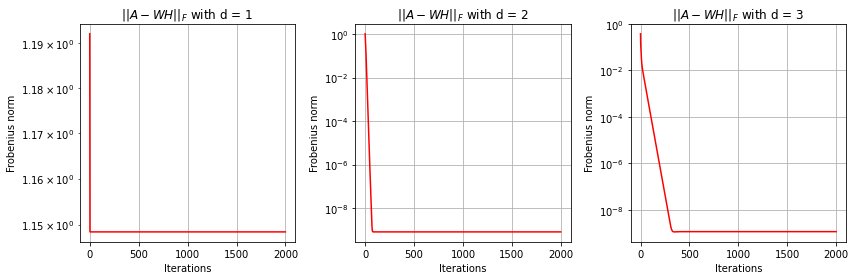

A = A4


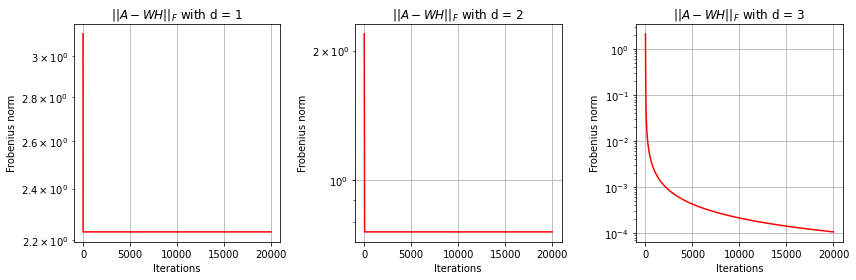

In [17]:
print("A = A3")
plotFroNorm(A3, (1,2,3), maxiter=2000)
print("A = A4")
plotFroNorm(A4, (1,2,3), maxiter=20000)


In the figure above, we have plotted Frobenius norm as a function of the number of iterations, for different values of $d$. Every graph tends to decrease, so the relation $||A-W_{k+1}H_{k+1}|| \leq ||A-W_{k}H_{k}||$ is satisified. From the plots we observe that if $d$ is equal to or greater than the rank of the relevant matrix, then the Frobenius norm reaches its lowest value if it runs indefinitely. This is very clear from the plots for $ d = 2 $ and $ d = 3 $ for $ A_3 $. As the number of iterations approach infinity these graphs converge towards (roughly) the same value. We note that $d=3$ results in a slower convergence, as is to be expected because $d=3$ results in bigger matricies, so we need more elements to reach the equilibrium. 

For $d < rank(A)$, we see that the norm reaches a lower value as we increase $d$. This is because the constructed $W$ is able to span a larger subset of the span of the column vectors of $A$.

The reason that $d \geq rank(A)$ results in $||A-WH||_F$ approaching a specific value may be understood like this:
the rank of a matrix tells us how many basis vectors are needed to span the entire vector space spanned by the column vectors of this matrix. So if we let $d = rank(A)$, it will thus be possible for $W$ to be formed such that its column vectors span the same vector space as the column vectors of $A$. It is then only a matter of forming $H$ such that the column vectors of $WH$ align with the column vectors of $A$. The important thing to note here is that an increased value for $d$ doesn't result in $WH$ being closer to $A$, because there are no desirable column vectors this new $W$ could have that the old $W$ couldn't already span.

If we run this test for different rng seeds, one might find that all the graphs aren't strictly decreasing. This is the result of the $\delta$ value we were forced to add to avoid division by zero errors. Though this error could be diminished if we chose $\delta$ to be of an order significantly lower than the order of the Frobenius norm. But since we are forced to choose some specific value for $\delta$, we will simply accept that the Frobenius norm could in some cases be diminished further still if we chose to neglect to add a $\delta$. 

## Task 2

We have hitherto looked into how NMFs work, and we are now prepeared to employ this newfound knowledge to solve the main problem of this project, namely compressing image sizes. By image size we only refer to the rgb part of the image. The new image size should correspond to the total amount of elements in the matrices used, thus giving us:

$ \dfrac{nd + md}{nm}= d\left(\dfrac{1}{n} + \dfrac{1}{m}\right)$

as the relative size of the image after NMF. So we can immediately see that $d$ should be less than $\frac{nm}{n+m}$ to ensure that the NMF actually reduces the image size. With $n=24\cdot 24\cdot 3 = 1728$, and $m=500$, we get that $d\leq 387$ ensures that the NMF decreases the image size.

In [18]:
def findRelativeImageSize(d):
    """
    Finds relative image size from d value assuming standard n and m value.
    Args:
        d: int
    returns:
        int
    """
    
    return d*(1/1728 + 1/500)

### a)

We start by plotting 63 random and one predetermined cryptopunks in an 8x8 grid. We chose one specific, notably different and rare, cryptopunk, which we have positioned as the first cryptopunk in the grid. We did this to see how well the algorithm fares with images that are distinctly different from the norm. It was important that the predetermined cryptopunk was rare, such that few or none of the other cryptopunks share its attributes.


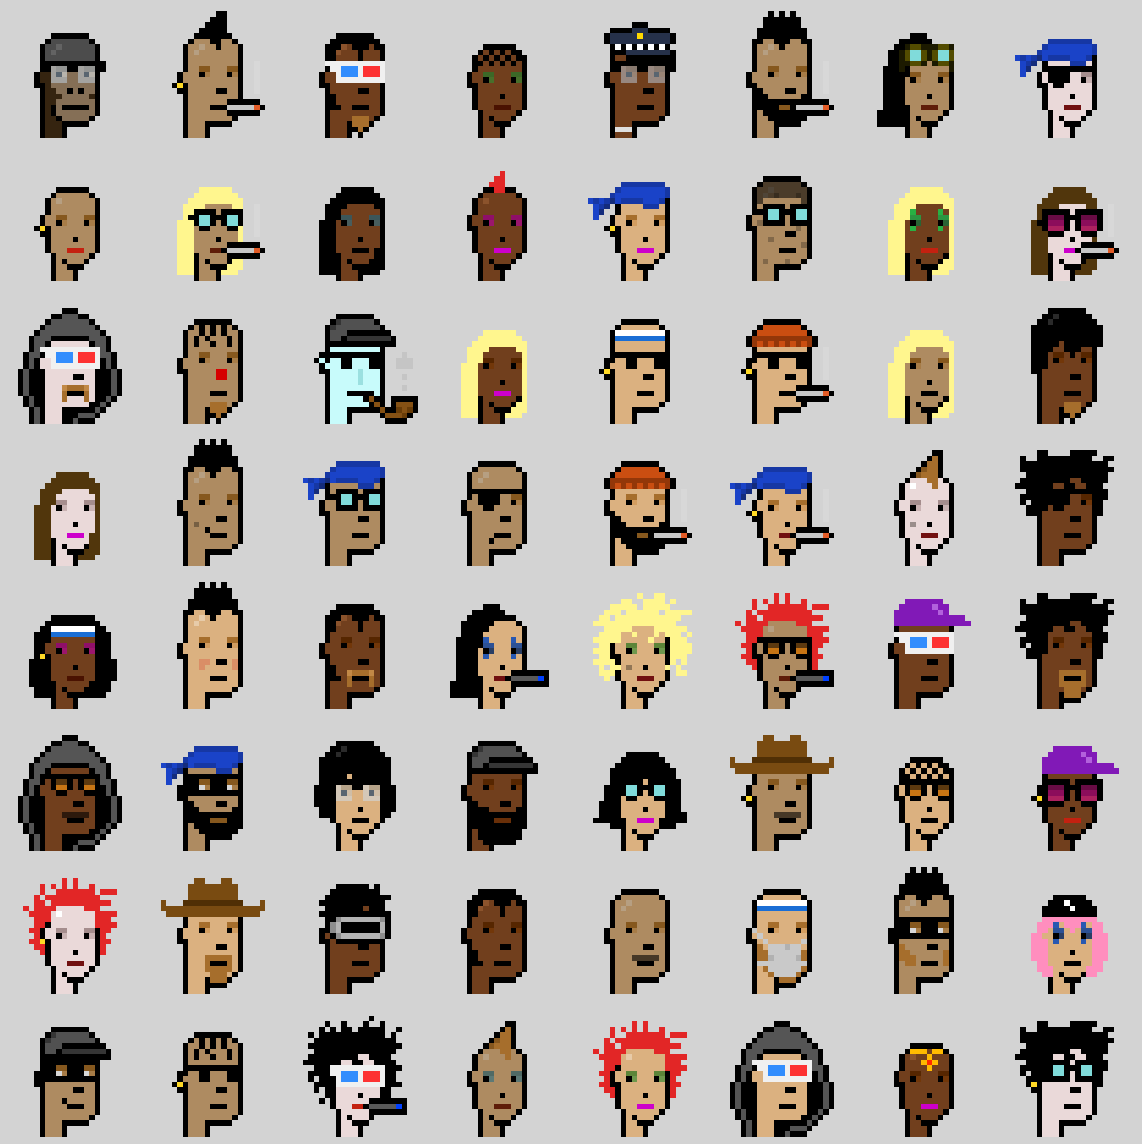

In [19]:
# Example of plotting 8 times 8 images and saving the output to a file named "punks.png"
plotimgs(IMGS, 8, filename="punks.png")

### b)

In [20]:
def createMeanImage(imgs):
    """
    Finds mean image
    Args:
        imgs: (n,m) array[float]
    Returns:
        array[float]
    
    """
    
    return np.mean(imgs, axis=-1)


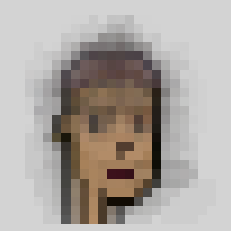

Rank of matrix with images: 406


In [21]:
plotimgs(createMeanImage(IMGS), 1, filename="meanPunk.png")
rank = np.linalg.matrix_rank(IMGS.reshape(-1, IMGS.shape[-1]))
print(f'Rank of matrix with images: {rank}')

Notice that the mean face still clearly retains a face structure, and note as well that using a different selection of images yields basicly the same result. This shows just how similar these face designs truly are, as a varied selection of images should yield an inconsistent mess.  

Around the face we have a cloud of transparent pixels, which is an average of the attributes of the various cryptopunks. We see that the attributes are very undefined, suggesting that their attributes differ immensely. You can see this quite obviously when you look at our 8x8 grid.

We can actually approximate how many different attributes exists among the characters, which may be gathered from the matrix rank. As discussed in problem 1g), the rank tells us how many column vectors are needed to span the the vector space spanned by the column vectors of the image, where each column vector may be considered as one attribute a character may possess. Then, by linearly combining these column vectors, one can form, at least, every character we have analyzed. It is worth noting that the NMF algorithm might not reach the global minimum for two reasons: the NMF algorithm needs to run indefinitly for it to reach a minimum, and the choice for $W_0$ and $H_0$ may cause it to reach a local minimum as opposed to the global minimum. 

The opacity of a pixel tells us something about how frequently this pixel is used across the cryptopunks. If we add pixels with the same opacity and then take the average, we will get back the exact same opacity. Thus, non-transparent pixels are indicative of pixels common for all cryptopunks. If we add pixels of different opacities and take the average, we end up with a pixel that appears to be blurry in the image. We may thus conclude that the cloudy pixels on the mean image are pixels which are only sometimes used across the cryptopunks.

### c)


We will now plot the column vectors of $W$ for various values of $d$. $W$ holds the various attributes of the cryptopunks.

In [22]:
def findBasisVectors(d, imgs_reshaped=IMGS_RESHAPED):
    """
    Finds NMF and returns W in correct format
    Args:
        d: int
        imgs_reshaped: (n,m) array[float]
    Returns:
        W_reshaped: (n,m) array[float]
    """
    
    W, H = NMF(imgs_reshaped, d)
    W_reshaped = reshapeToImage(W, withOpacity=False)
    return W_reshaped


def plotBasisVectors(W_reshaped, *, nplot, rescale):
    """
    Plots every column vector in W_reshaped
    Args:
        W_reshaped: (n,m) array[float]
        nplot: int
        rescale: bool
    """
    
    plotimgs(reshapeToImage(W_reshaped, withOpacity=False), nplot=nplot, rescale=rescale)


def plotBasisVectorsDifferentD(ds=(64, 25, 625), imgs_reshaped=IMGS_RESHAPED):
    """
    Plots W_reshaped for different d values
    Args:
        ds: array[int]
        imgs_reshaped: (n,m) array[float]
    """
    
    for d in ds:
        print(f"d = {d}:")
        plotBasisVectors(findBasisVectors(d, imgs_reshaped), nplot=int(np.sqrt(d)), rescale=True)


d = 64:


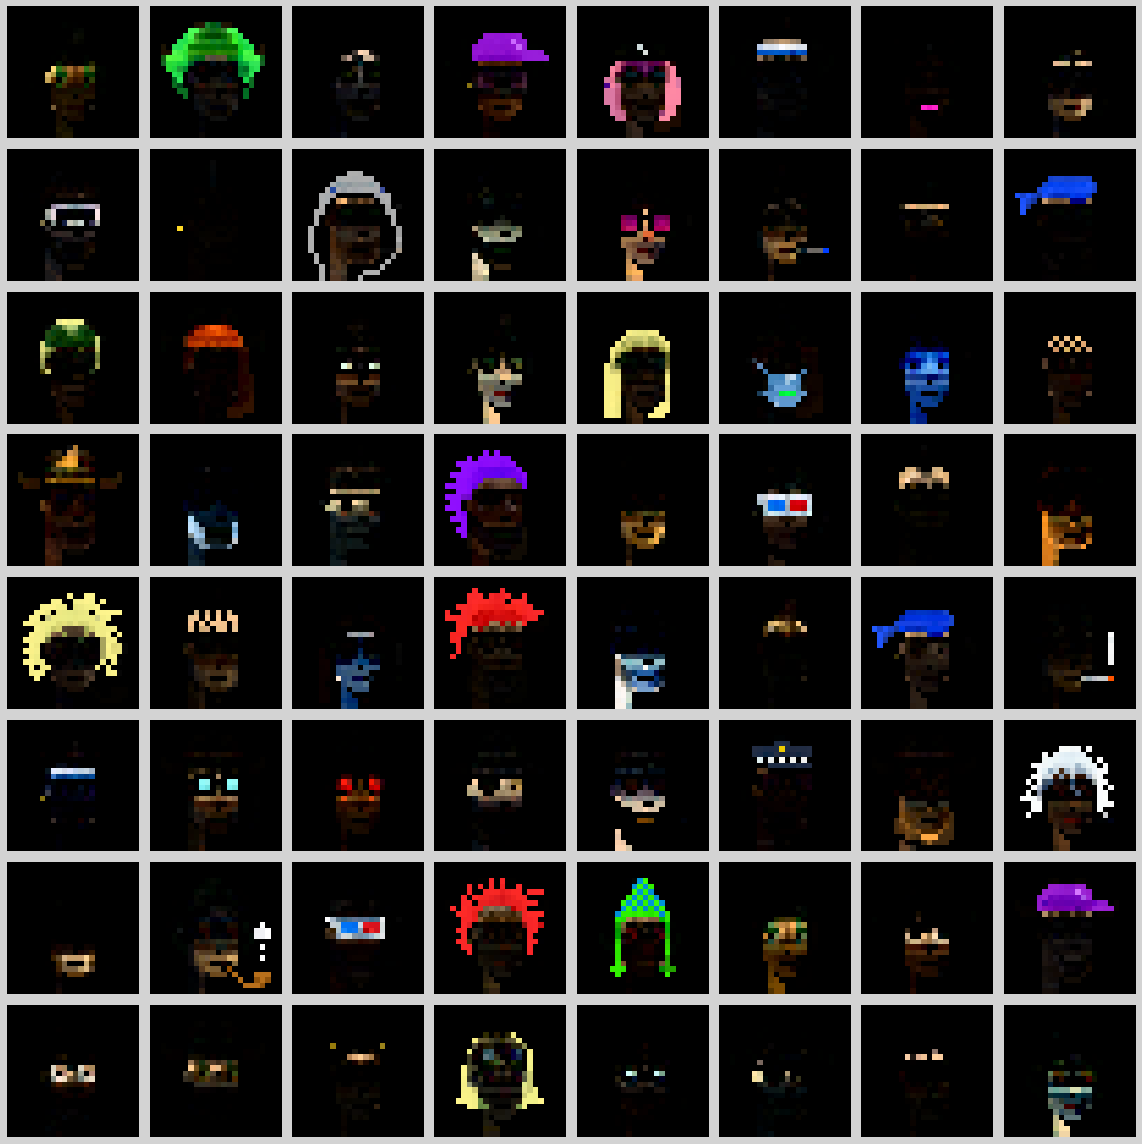

d = 25:


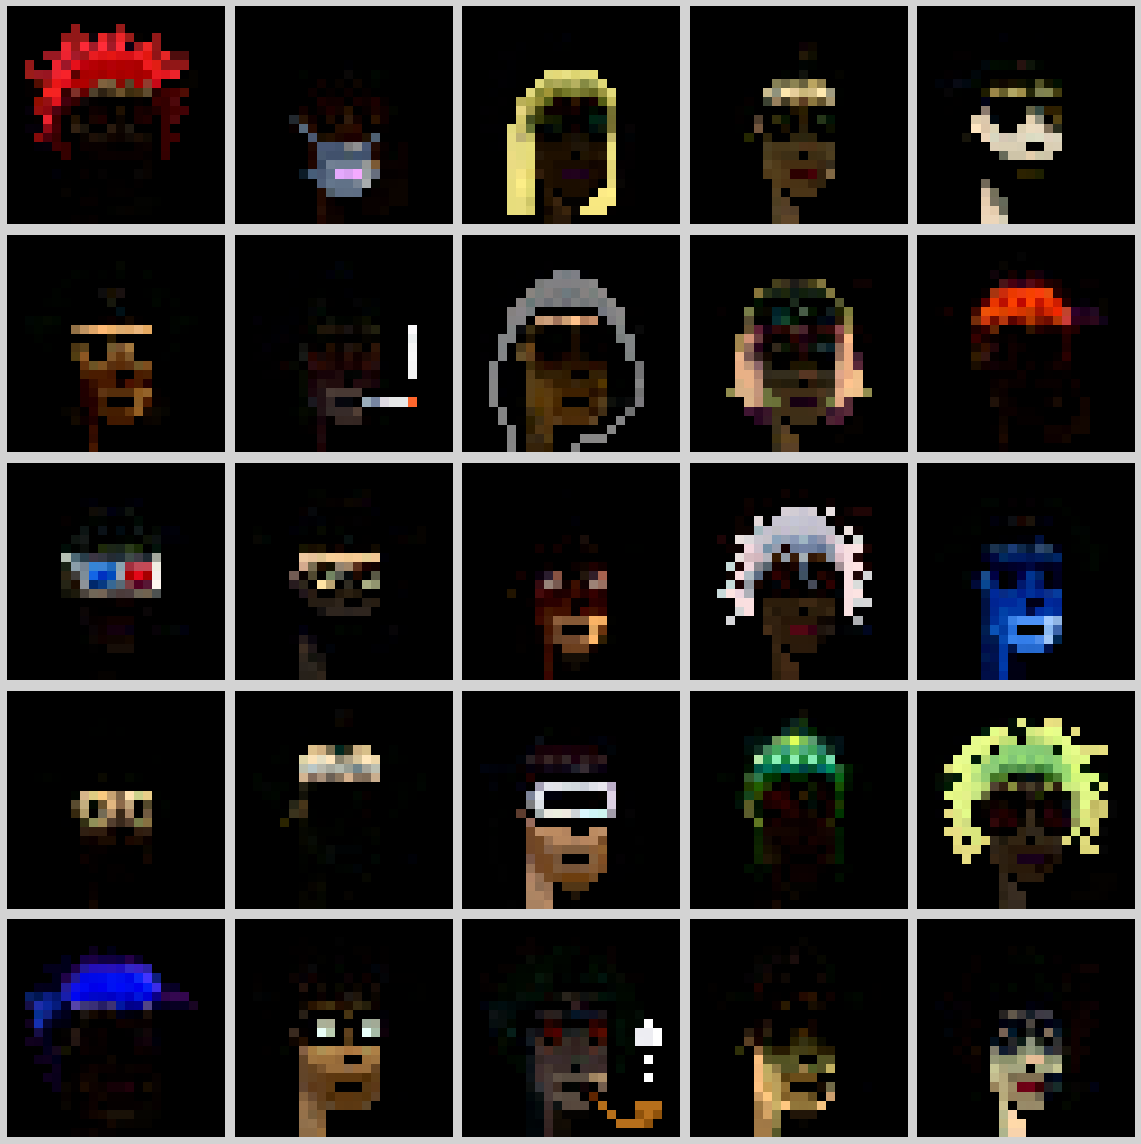

d = 625:


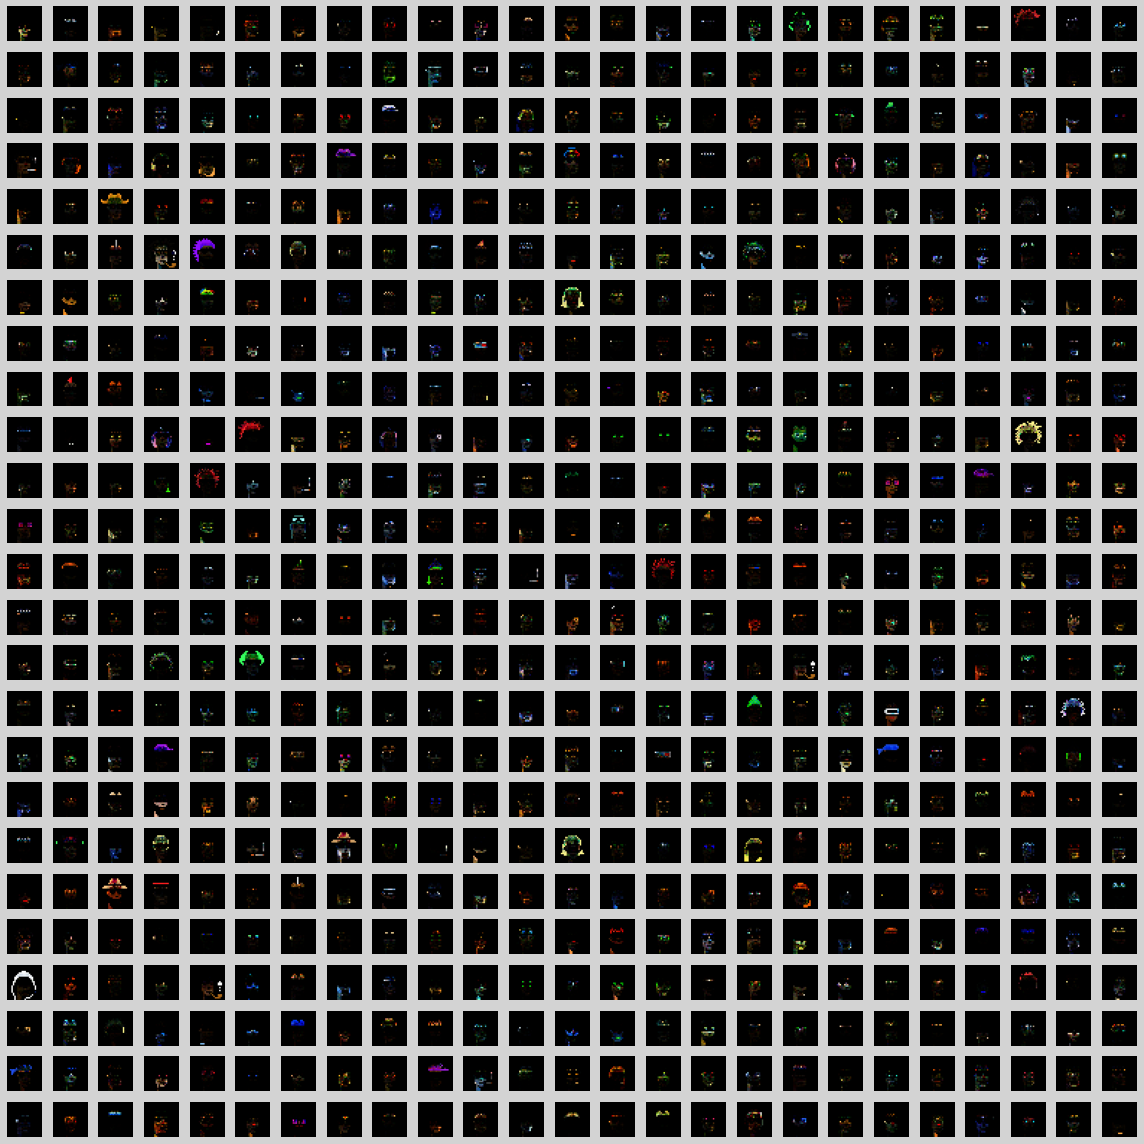

In [23]:
plotBasisVectorsDifferentD()

As can be seen, the $W$ did infact contain column vectors describing the different attributes one might find on the characters. We have tried multiple values for $d$ to get a better understanding for how the decomposition works. Choosing $d=25$ yields fairly broad attributes, containing multiple smaller attributes such as beard, glasses, hair and face all as one attribute. When we increase the value for $d$ we notice that the attributes become more specialized. Now cigarettes, glasses, hair and so on comes as individiual attributes as opposed to all of them being bundled together. The value of $d = 625$ is notable as being greater than the value for the rank of the images. Meaning that these attributes should fully describe the dataset. We notice that lesser details such as eyecolor, lipcolor, lesser pieces of jewelry, beards, and so on are now all distinct attributes. So the tendency is clearly that greater values for $d$ causes the attributes to be more specialized to a single property. 

There are however outliers such as for $d=64$, but also for $d=625$, where some attributes contain multiple properties such as entire faces. For $d=64$ this may be explained as a consequence of the relatively small value for $d$ causing frequently used attributes to become column vectors even tough they contain more properties than the usual attribute. For $d=625$ case however, these outliers may be explained as a consequence of having $d$ being greater than the rank of the images. This allows for some superfluous column vectors, which would explain why some faces emerge as column vectors despite their properties also being available as distinct attributes on their own. 

### d)

In [24]:
def reconstruct(d, imgs_reshaped=IMGS_RESHAPED):
    """
    Reconstructs A from NMF
    Args:
        d: int
        imgs_reshaped: (n,m) array[float]
    returns:
        (n,m) array[float]
    """
    
    W, H = NMF(imgs_reshaped, d)
    return W @ H


def plotReconstruct(imgs_reconstructed, imgs_opacity=IMGS_OPACITY, *, rescale, addOpacity=False):
    """
    Plots A reconstructed from NMF 
    Args:
        imgs_reconstructed: (n,m) array[float]
        rescale: bool
    """
    if addOpacity:
        imgs = addOpacityChannel(imgs_reconstructed, imgs_opacity)
    else:
        imgs = reshapeToImage(imgs_reconstructed, withOpacity=False)
    plotimgs(imgs, rescale=rescale)


def plotReconstructDifferentD(ds=(64, 25, 625), imgs_reshaped=IMGS_RESHAPED, imgs_opacity=IMGS_OPACITY, *, addOpacity=False):
    """
    Plots A reconstructed from NMF using different d values
    Args:
        ds: array[int]
        imgs_reshaped: (n,m) array[float]
    """
    
    for d in ds:
        print(f"d = {d}:")
        plotReconstruct(reconstruct(d, imgs_reshaped), imgs_opacity, rescale=True, addOpacity=addOpacity)


d = 64:


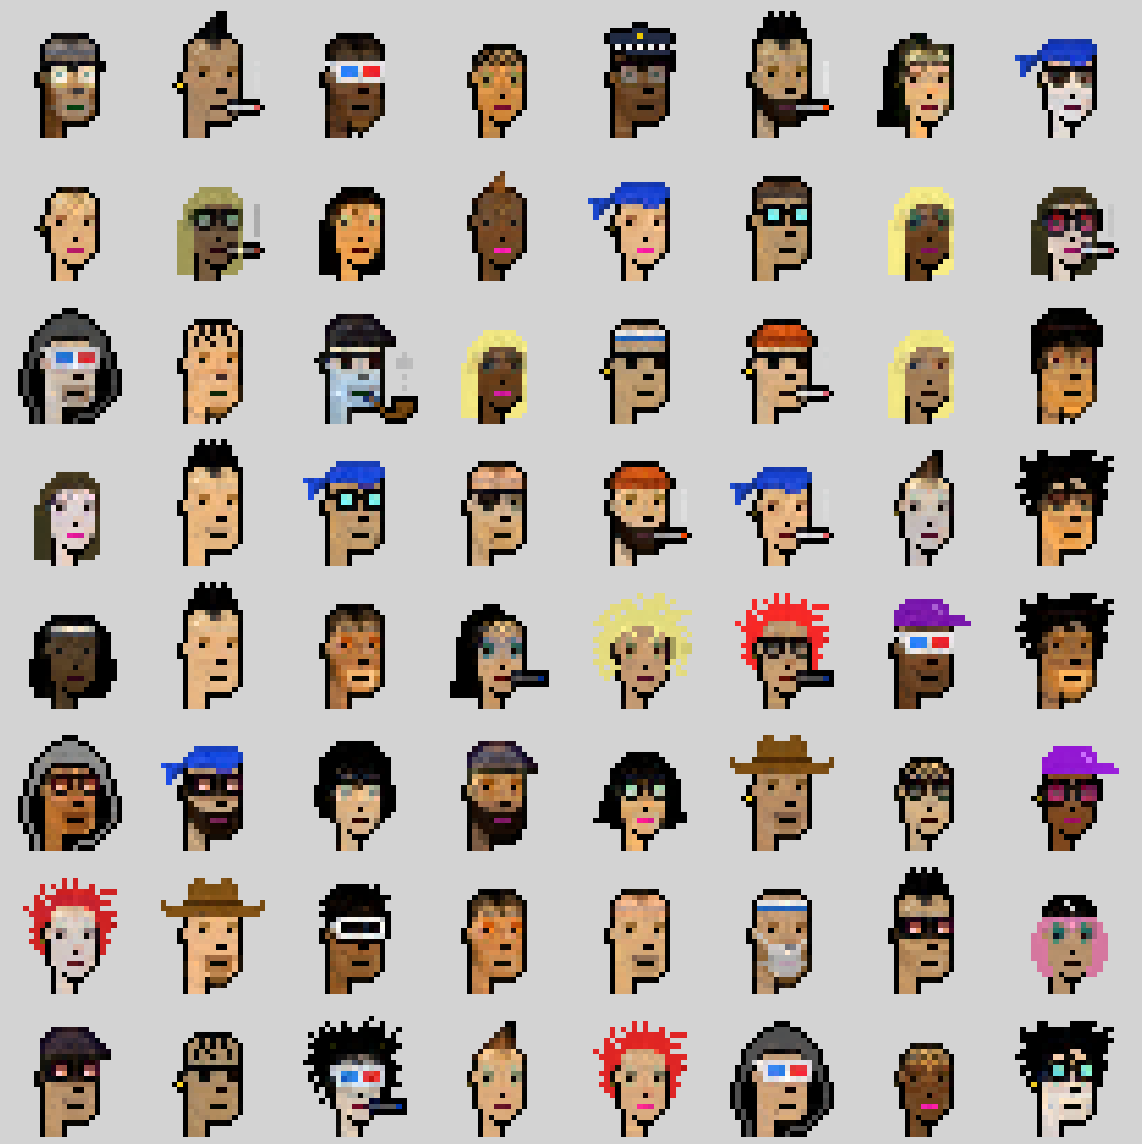

d = 25:


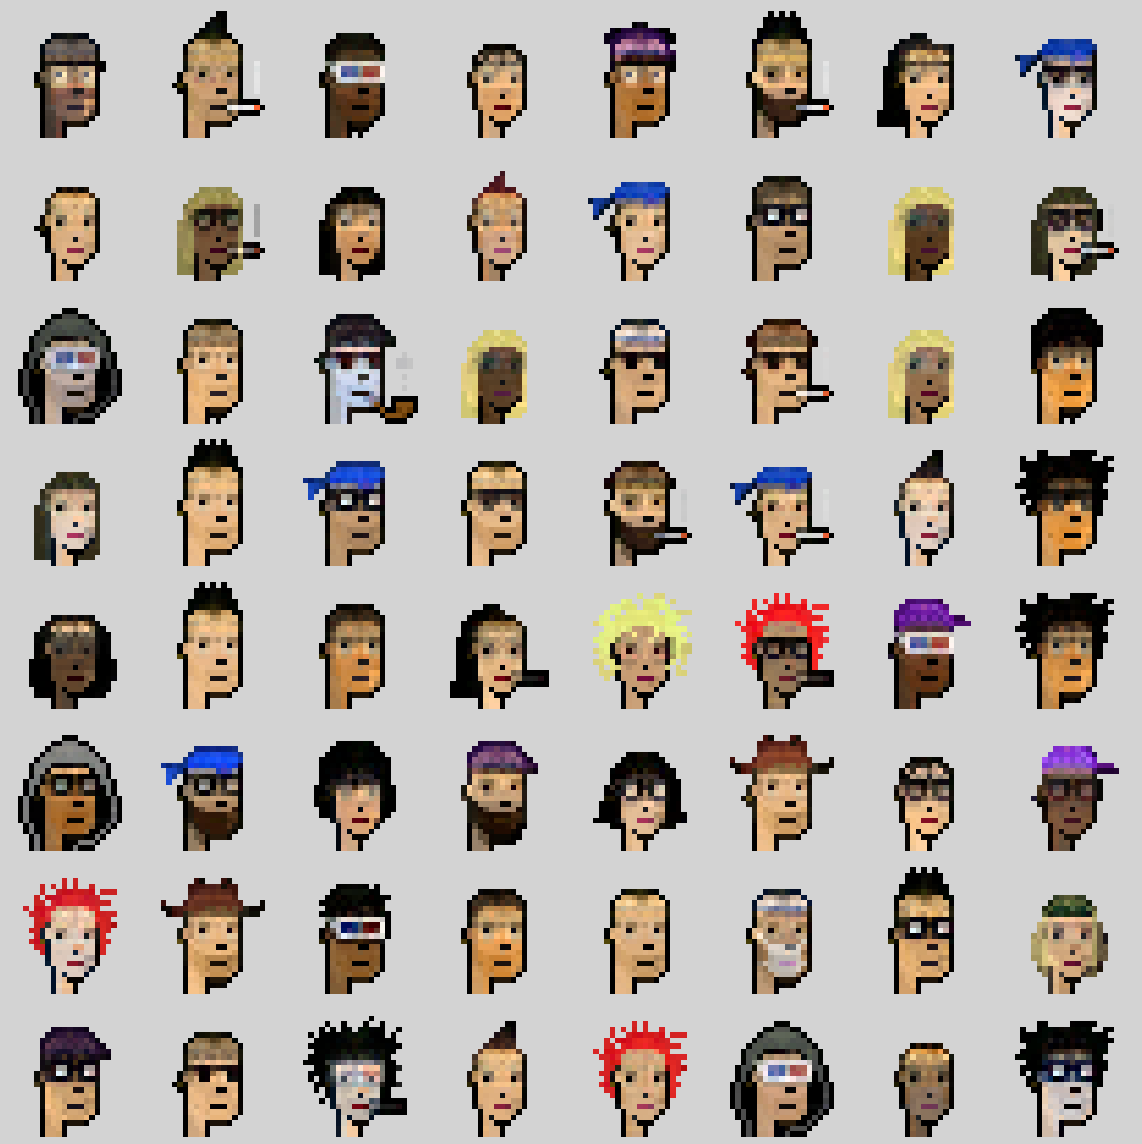

d = 625:


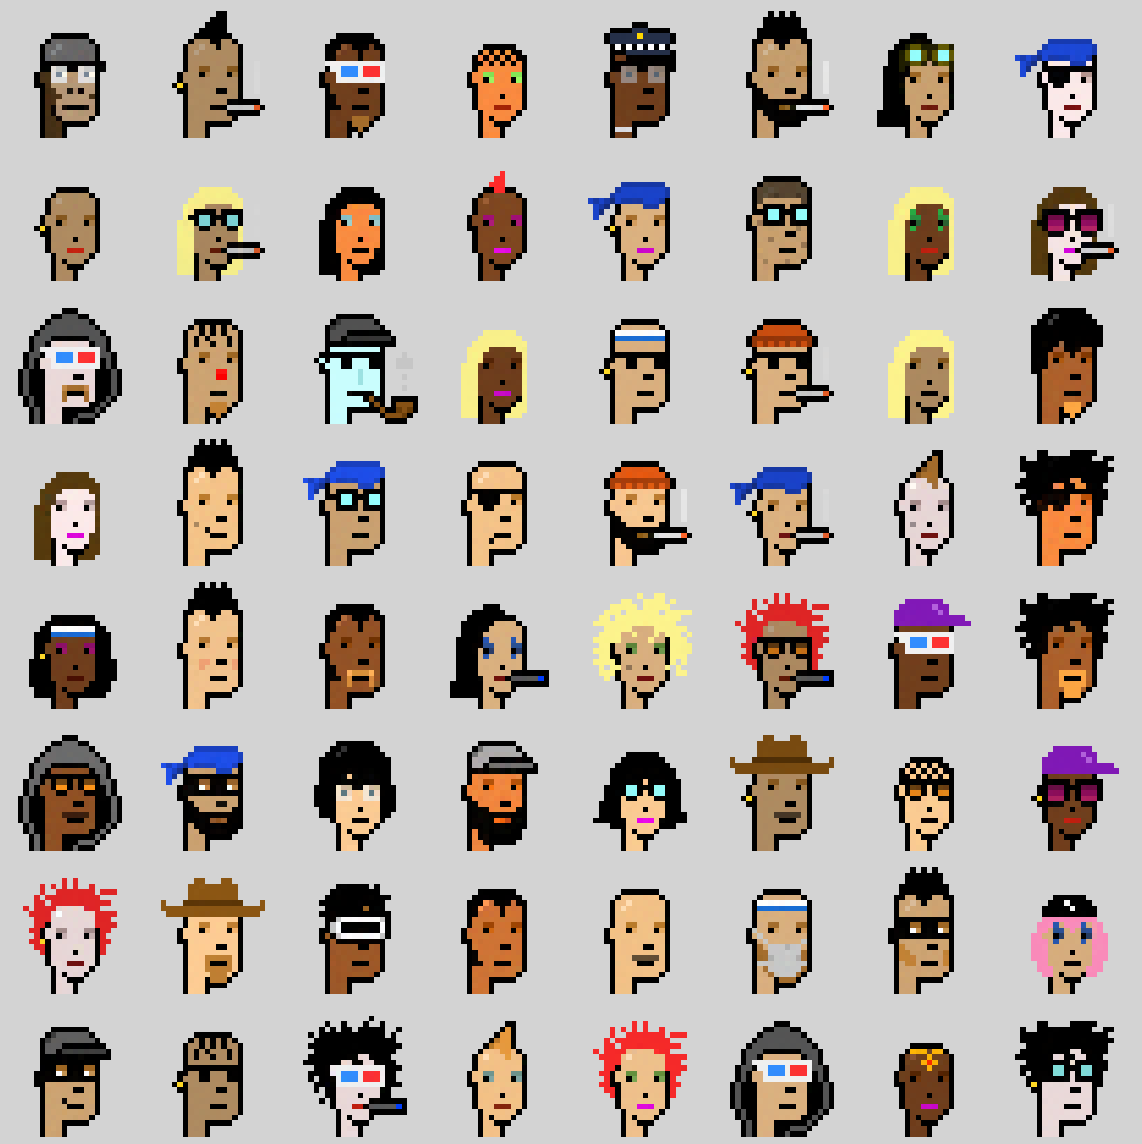

In [25]:
plotReconstructDifferentD(addOpacity=True)

In [26]:
norm = np.linalg.norm(reconstruct(64, IMGS_RESHAPED) - IMGS_RESHAPED, 'fro')
print(f'The frobenius norm of the difference between the reconstruction with d=64, and the original images is: {norm:.2f}')

The frobenius norm of the difference between the reconstruction with d=64, and the original images is: 39.70


We have added back the opacity channel to the pictures, thus making it easier to distinguish darker attributes.  

##### We will initially consider $d=64$:

We first turn our attention to the attributes and faces. The shape of the attributes and faces has been reconstructed incredibly well. The colours however, were not preserved as well. An overall trend seems to be that the colours have become somewhat brighter, and the attributes have become more pixelated. It seems that small attributes, such as earrings, cigarettes, and glasses have held up best.

The results are affected by the selected $d$ value. If $d$ is less than the rank of the matrix, we will not be able to retrieve complete information from all the column vectors, as discussed in 1g) and 2b). The matrix rank is ~400, so the value $ d = 64 $ is quite small in comparison. This explaines the discrepancies between the reconstruction and the original image.

We will now turn our attention to the first cryptopunk, which was chosen to be quite different from the others. As we can see, the reconstruction failed to recreate the essence of the original image, as it now looks more like the other cryptopunks. This is because the dataset is lacking in attributes which coincide with the attributes of the first cryptopunk.

The value of the norm is difficult to interprete at the present time, but it will prove useful when we are dealing with noise later.

##### Looking at the reconstructions with different $d$ values:

For a low $d$ value, the reconstruction doesn't retain information about the least widespread attributes. This is to be expected as described in task 2c). The recreation for high $d$ values leads to an almost perfect recreation, even the first cryptopunk looks like it did originally. This is also expected as described in task 2c).

### e)

The value of $ d $ has a great impact on the reconstruction. We will now look at how the norm depends on $d$

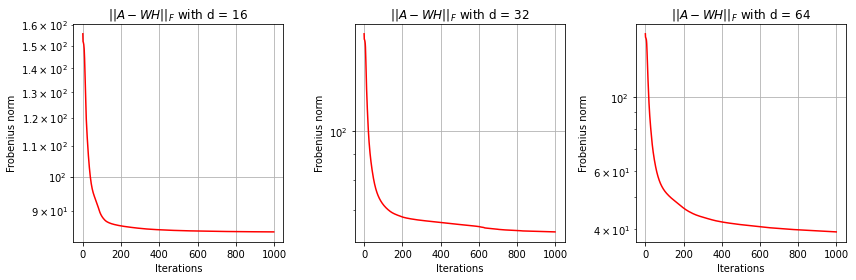

In [27]:
plotFroNorm(IMGS_RESHAPED, (16, 32, 64))

The norm convergers towards lower values for greater values of $d$. This is expected, as described 1g). 


### f)

In [28]:
def plotFroNormWithRespectToD(A, d_tuple, maxiter=1000):
    """
    Plots Frobenius norm of A-WH with respect to d
    Args:
        A: (n,m) array[float]
        d_tuple: array[int]
        maxiter: int
    """
    
    norms = np.zeros(len(d_tuple))
    for i in range(len(d_tuple)):
        W, H = NMF(A, d_tuple[i], maxiter=maxiter)
        norms[i] = np.linalg.norm(A - W @ H, 'fro')
    plt.figure()
    plt.scatter(d_tuple, norms)
    plt.show()

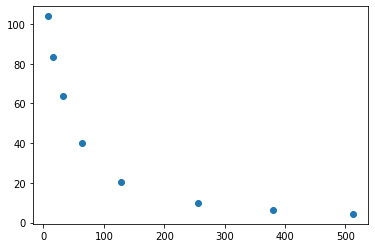

In [29]:
plotFroNormWithRespectToD(IMGS_RESHAPED, (8, 16, 32, 64, 128, 256, 380, 512))

As the value for $d$ increases, the norm converges. Which it does, not surpirsingly, around the value 400, which is about the rank of the images. We notice that the graph is strictly decreasing, this is because an increased value for $d$ may only increase the amount of detail that the NMF is able to contain.

### Task 3)

Most images will most probably contain some amount of noise, that is to say a discepancy between the desired image, and the saved image. We will now implement this in our dataset.

### a)

We start in a similar way as in problem 2a). We make an 8x8 matrix containg the same characters, but this time with noise.

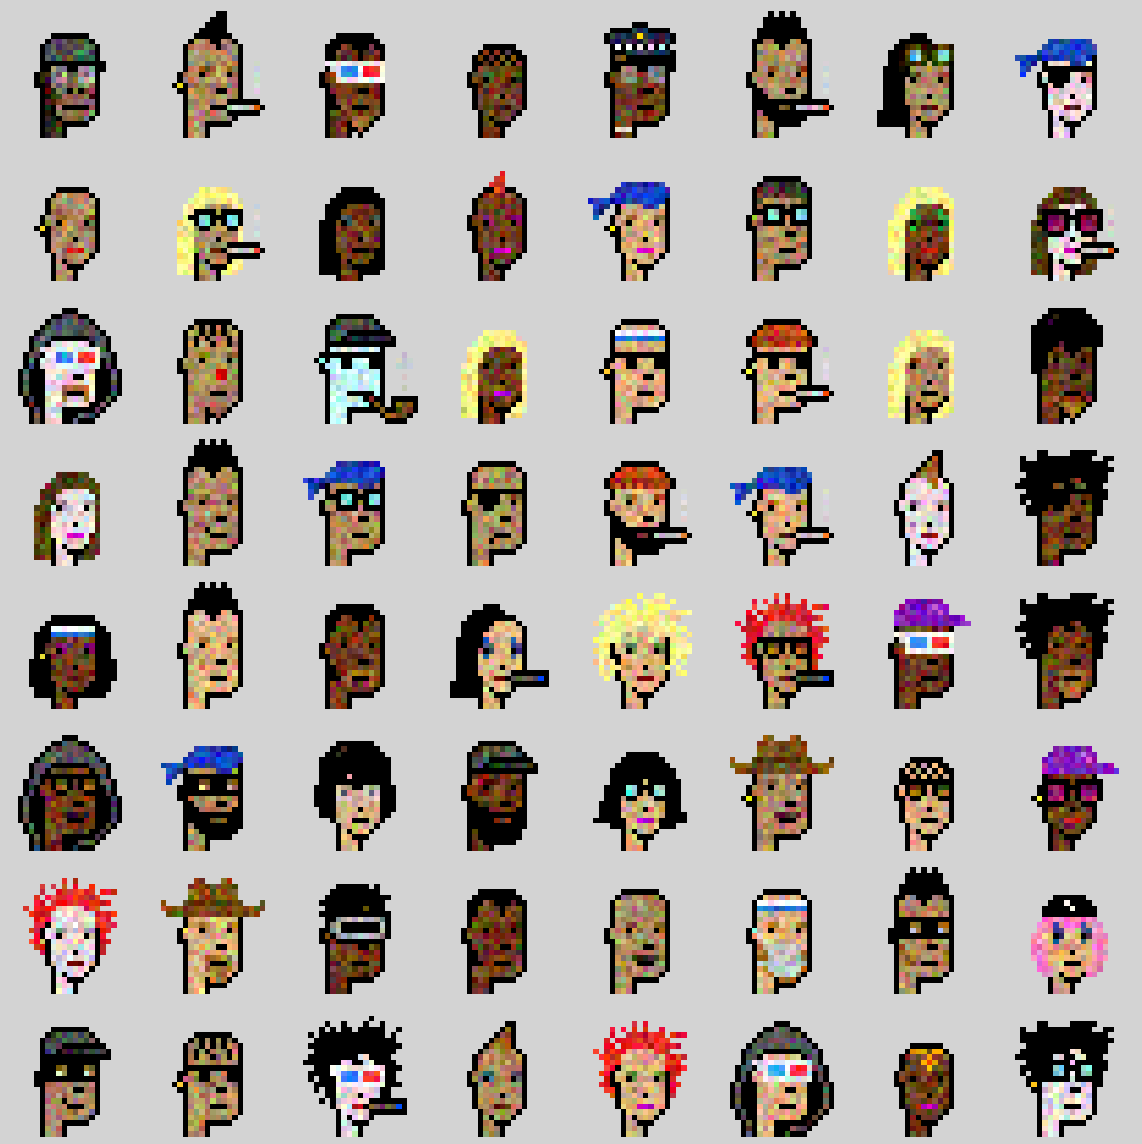

The Frobenius norm of difference between the dataset and the noisy dataset is: 42.00


In [28]:
# Example of plotting 8 times 8 images with noise
imgsNoise(IMGS_NOISY_1, IMGS, splitImages(IMGS))

print(f"The Frobenius norm of difference between the dataset and the noisy dataset is: {np.linalg.norm(IMGS_RESHAPED - IMGS_NOISY_1, 'fro'):.2f}")

It is worth noting that the norm is greater than the norm of the difference between the reconstruction and the original images. Indicating that the noise is going to be problematic to get rid of.

### b)

In [29]:
def reconstructFromNoisyImgs(d, imgs_noisy=IMGS_NOISY_1, imgs_opacity=IMGS_OPACITY, *, addOpacity=False):
    """
    Reconstructs A from noisy images.
    Args:
        d: int
        imgs_noisy: (n,m) array[float]
    """
    
    W, H = NMF(imgs_noisy, d)
    print('Columns of W:')
    plotBasisVectors(W, nplot=int(np.sqrt(d)), rescale=True)
    print('Reconstruction:')
    plotReconstruct(W @ H, imgs_opacity, rescale=True, addOpacity=addOpacity)


Columns of W:


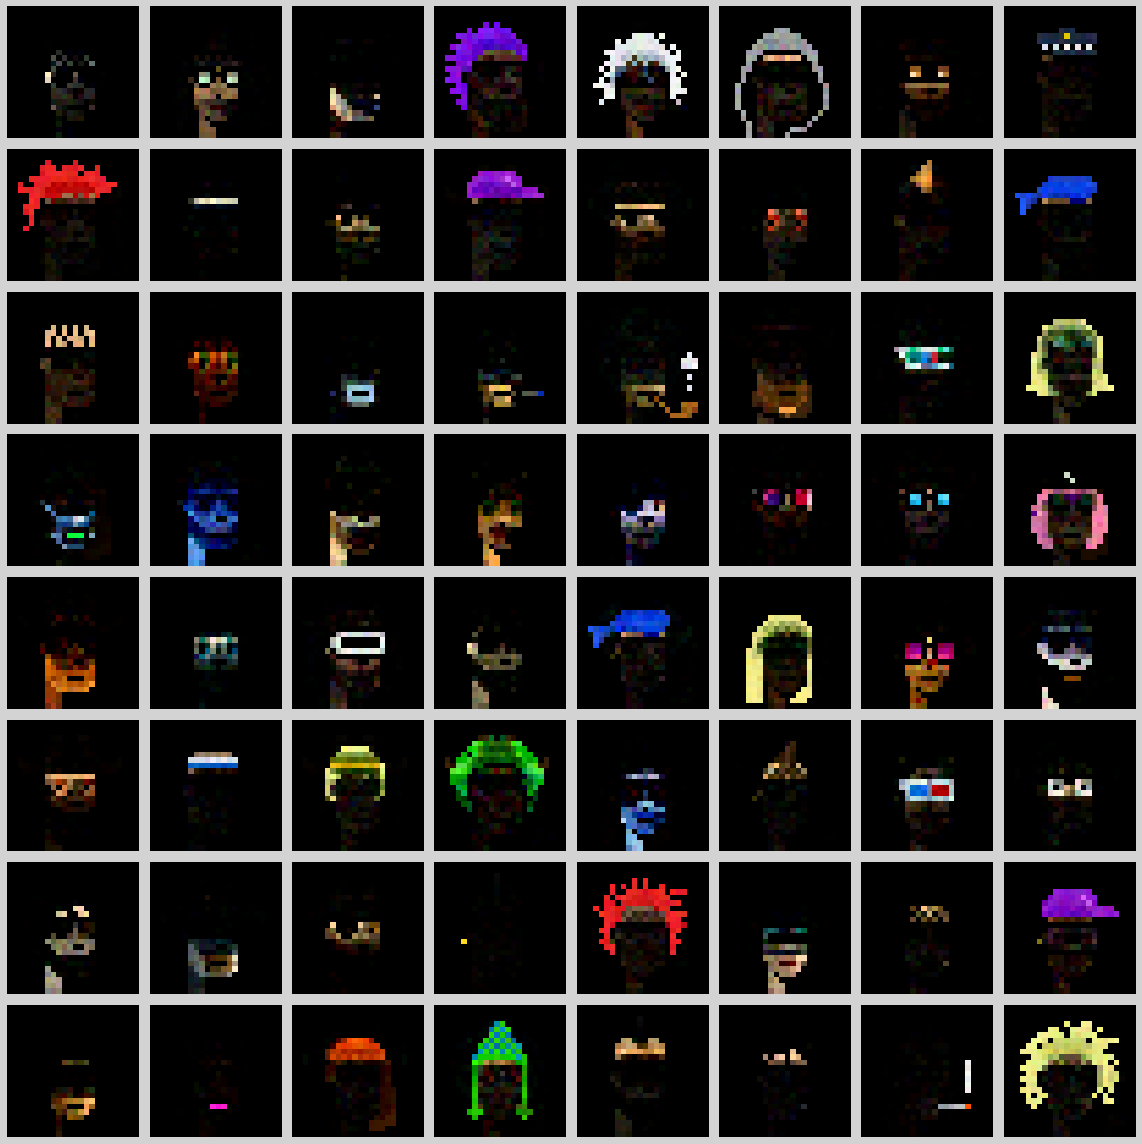

Reconstruction:


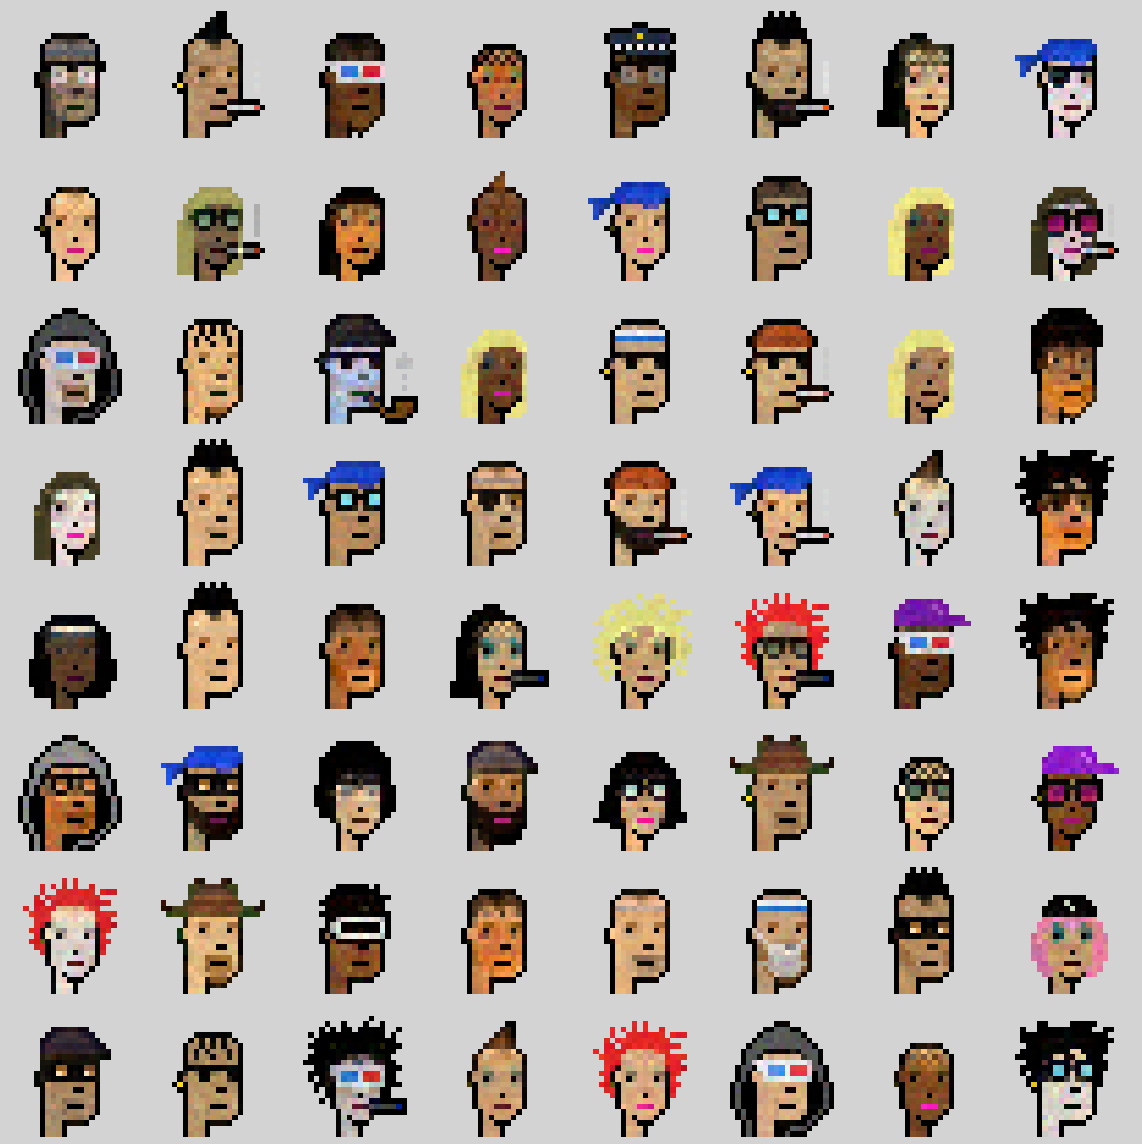

In [30]:
reconstructFromNoisyImgs(64, addOpacity=True)

In [31]:
norm = np.linalg.norm(reconstruct(64, IMGS_RESHAPED) - reconstruct(64, IMGS_NOISY_1), 'fro')
print(f'The frobenius norm of the difference between the noisy reconstruction and non-noisy reconstruction is: {norm:.2f}')

The frobenius norm of the difference between the noisy reconstruction and non-noisy reconstruction is: 30.15


In [32]:
norm = np.linalg.norm(IMGS_RESHAPED - reconstruct(64, IMGS_NOISY_1), 'fro')
print(f'The frobenius norm of the difference between the noisy reconstruction and the original images is: {norm:.2f}')

The frobenius norm of the difference between the noisy reconstruction and the original images is: 44.12


The frobenius norm of the difference between the noisy reconstruction and the original images, compared to the norm with the non-noisy reconstruction, is slightly worse. Meaning that the noisy reconstruction is almost as faithfull to the original images compared to the reconstruction without noise. In fact it is quite difficult to distinguish the noisy and the non-noisy reconstructions, so we have therefore calculated the norm of the difference between them. This value is relativly low, confirming that the noisy reconstruction went fairly smoothly. This goes against our assumption, that the noise would be difficult to get rid of, showing how effective NMF is at removing noise.

### c)

In [35]:
def plotNoisyRecontructionErrorWithRespectToD(d_tuple, imgs_noisy=IMGS_NOISY_1, imgs_reshaped=IMGS_RESHAPED, *, maxiter=1000):
    """
    Plots the norm of the difference between the original images and the reconstructed images,
    with respect to d.
    Args:
        d_tuple: array[int]
        img_noisy: (n,m) array[float]
        imgs_reshaped: (n,m) array[float]
        maxiter: int
    """
    
    num = len(d_tuple)
    reconstructionError = np.zeros(num)
    executionTimes = np.zeros(num)
    asymptoticError = np.linalg.norm(imgs_reshaped - imgs_noisy, 'fro')
    for i in range(num):
        start_time = time.perf_counter()
        W, H = NMF(imgs_noisy, d_tuple[i], maxiter=maxiter)
        reconstructionError[i] = np.linalg.norm(imgs_reshaped - W @ H, 'fro')
        executionTimes[i] = time.perf_counter() - start_time
        
    plt.figure()
    plt.scatter(d_tuple, reconstructionError)
    plt.axhline(asymptoticError, color="purple", label="$||A - A_{noisy}||_F$")

    plt.title("Reconstruction error by $d$ value")
    plt.xlabel("$d$")
    plt.ylabel("$||A - WH||_F$")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.scatter(d_tuple, executionTimes)
    
    plt.title("Runtime by $d$ value")
    plt.xlabel("$d$")
    plt.ylabel("Runtime [s]")
    plt.grid(True)
    plt.show()

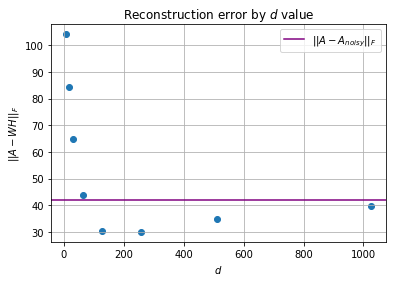

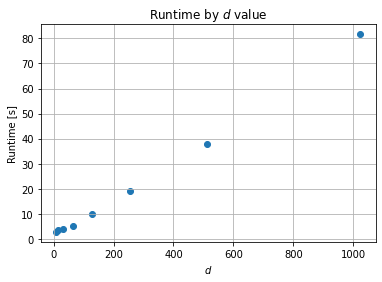

In [36]:
plotNoisyRecontructionErrorWithRespectToD((8, 16, 32, 64, 128, 256, 512, 1024))

We have here plotted the norms for different $ d $ values. The norm decreases for increasing $ d $ values, giving rise to the term underfitting. If we were to choose a value for $d$ that is too low, the column vectors give insufficient information to reconstruct the dataset. For greater values of $d$, the curve will increase when $ d $ increases further yet, which gives rise to the term overfitting. Although we provide the column vectors with more information to reconstruct the system, NMF seems to be doing a worse job. The reason for this is noise in the dataset. The noise causes the column vectors to eventually comform to the noise for increased values of $d$. Though this gives column vectors that better comform with the data it was given, we would prefer if it instead returned a denoised version of this data. And this may be accomplished if we choose too few column vectors to properly pick up the noise. We must thus balance having enough column vectors to get proper information from the dataset, but not too many column vectors, such that we recreate it imperfectly by not picking up the noise. 

When $d$ approches infinity, $WH$ approaches the noisy version of the images. Meaning that we expect the graph to asymptoticly reach the Frobenius norm of the difference between the original images and the noisy version of those images.
Prior to this asymptote the value of $||A-WH||_F$ may very well be less than this, which it indeed is as can be seen from the graph.

For a value of $ d $ the curve seems to reach a minimum. There is no analytical way to find the $d$ value which yields the minimum of the graph, so we will instead use a numerical method to estimate the mathematically best value for $d$. 

In [37]:
def findMinimalErrorWithNoise(imgs_noisy=IMGS_NOISY_1, imgs_reshaped=IMGS_RESHAPED, *, n=8, maxiter=1000):
    """
    Approximates d value which yields minimum norm of the difference between the original images and 
    the reconstructed images.
    Args:
        imgs_noisy: (n,m) array[float]
        imgs_reshaped: (n,m) array[float]
        n: int
        maxiter: int
    Returns:
        optimalD: int
    """
    
    plt.figure(figsize=(7, 7))
    n = int(n)
    assert n > 2, "N must be at least 3 to find a minimum"
    low = 1
    high = min(imgs_noisy.shape)
    while high - low > n:
        spacing = (high - low) / n
        err = np.zeros(n + 1)
        ds = np.zeros(n + 1)
        for i in range(n + 1):
            d = round(low + spacing * i)
            W, H = NMF(imgs_noisy, d, maxiter=maxiter)
            err[i] = np.linalg.norm(imgs_reshaped - W @ H, 'fro')
            ds[i] = d
        index = err.argmin()
        low, high = int(np.floor(low + spacing * (index - 1))), int(np.ceil(low + spacing * (index + 1)))

        plt.scatter(ds, err)

    err = np.zeros(high - low)
    ds = np.arange(low, high)
    for i, d in enumerate(ds):
        W, H = NMF(imgs_noisy, d, maxiter=maxiter)
        err[i] = np.linalg.norm(imgs_reshaped - W @ H, 'fro')

    plt.scatter(ds, err)
    index = err.argmin()
    optimalD = low + index

    plt.plot(optimalD, err[index], marker=(4, 1, 45), color="r", markersize=10)
    plt.text(optimalD + 2, err[index] + 5, f"$d_{{optimal}}$ = {optimalD}")
    plt.axvline(optimalD, color="purple")
    
    plt.title("Point evaluations and optimal $d$")
    plt.xlabel("$d$")
    plt.ylabel("$||A - WH||_F$")
    plt.grid(True)
    plt.show()

    return optimalD

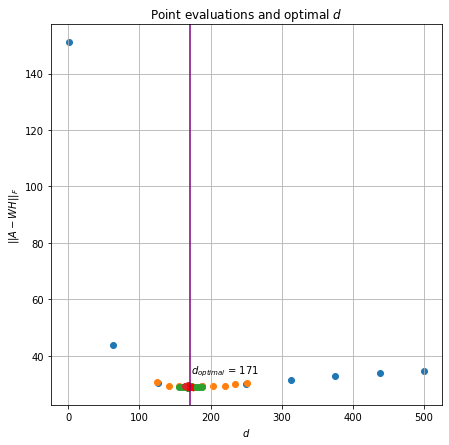

Approximate d value which reaches global minimum 171
The relative image size of the compressed image is: 44.10%


In [38]:
OPTIMAL_D_1 = findMinimalErrorWithNoise(IMGS_NOISY_1)
RELATIVE_IMAGE_SIZE_1 = findRelativeImageSize(OPTIMAL_D_1)
print(f"Approximate d value which reaches global minimum {OPTIMAL_D_1}")
print(f"The relative image size of the compressed image is: {RELATIVE_IMAGE_SIZE_1*100:.2f}%")

The NMF of the noised data using the approximated value for the mathematically best $d$, will not only be more faithfull to the original image than the original noised data, it is also less than half of the image size. This properly showcases the potential of NMFs. Though it should be mentioned, that determining the mathematically best $d$ value is computationaly very expensive.

We will now turn our attention to different values of noise level: $\sigma = 0.05$ and $\sigma = 0.2$

#### $\sigma = 0.05$:

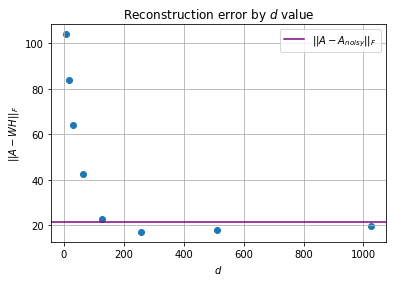

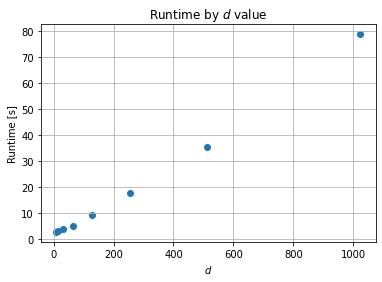

In [39]:
plotNoisyRecontructionErrorWithRespectToD((8, 16, 32, 64, 128, 256, 512, 1024), imgs_noisy=IMGS_NOISY_05)

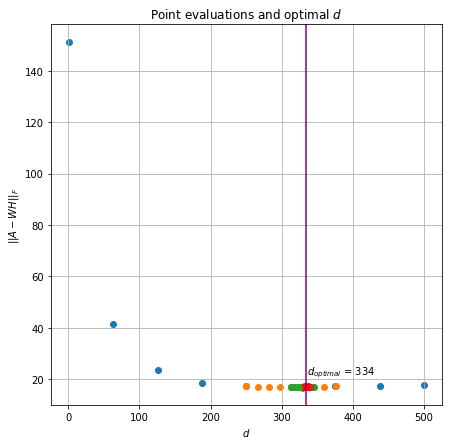

Approximate d value which reaches global minimum 334
The relative image size of the compressed image is: 86.13%


In [40]:
OPTIMAL_D_05 = findMinimalErrorWithNoise(IMGS_NOISY_05)
RELATIVE_IMAGE_SIZE_05 = findRelativeImageSize(OPTIMAL_D_05)
print(f"Approximate d value which reaches global minimum {OPTIMAL_D_05}")
print(f"The relative image size of the compressed image is: {RELATIVE_IMAGE_SIZE_05*100:.2f}%")

#### $\sigma = 0.2$:

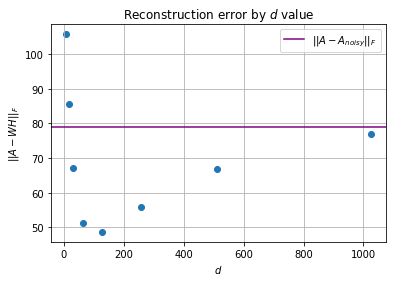

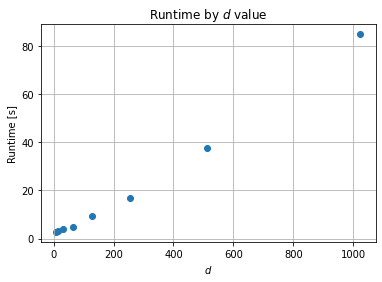

In [41]:
plotNoisyRecontructionErrorWithRespectToD((8, 16, 32, 64, 128, 256, 512, 1024), imgs_noisy=IMGS_NOISY_2)

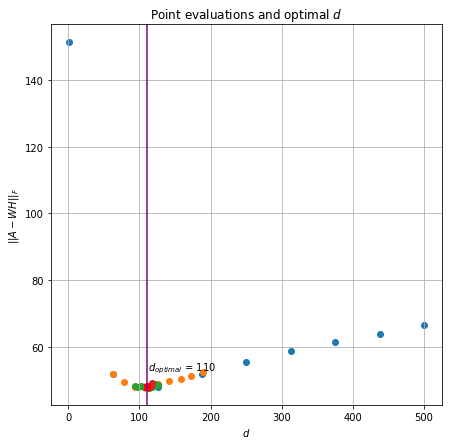

Approximate d value which reaches global minimum 110
The relative image size of the compressed image is: 28.37%


In [42]:
OPTIMAL_D_2 = findMinimalErrorWithNoise(IMGS_NOISY_2)
RELATIVE_IMAGE_SIZE_2 = findRelativeImageSize(OPTIMAL_D_2)
print(f"Approximate d value which reaches global minimum {OPTIMAL_D_2}")
print(f"The relative image size of the compressed image is: {RELATIVE_IMAGE_SIZE_2*100:.2f}%")

When we increase the noise in the images sample, it is readily seen from the graphs that the norm tends to increase for every value of $d$.  This is because more noise always causes some noise in the reconstruction.  

As can readily be seen, decreasing $\sigma$ causes the optimal $d$-value to increase. This is because a smaller $\sigma$ is analogous to less noise, implying that the noisy image is closer to the correct image. We may thus have a greater amount of column vectors before it starts picking up the noise. However, using this $d$ value increases the relative image size. One might therefore benefit from taking the NMF of the reconstructed image to decrease the image size, by choosing a lower $d$ value. 
Similarly incresing $\sigma$ causes the optimal $d$-value to decrease for an analgous reason, in this case however, there is less of a benefit to take NMF of the reconstructed image, since its relative image size is lower. 

We have also considered the time it takes to run the algorithm, showing that there is a roughly linear relation between the time it takes to run, and the value for $d$. This is because the most demanding operation being done is matrix multiplication, where $O(nmd)$, implying linear growth if we only increase $d$.

# Conclusion

Efficient data storage is of great importance, and we have acomplished it in this project using NMF. NMF works by approximating a factorization of a $n\times m$ matrix into a $n\times d$ matrix and a $d\times m$ matrix. 

We studied a large dataset containing images given as a $n\times m$ matrix. We discovered some information about the dataset, including that the cryptopunks are similar, especially their faces. Their attributes were somewhat more unique, which can be seen from the fact that the matrix has a high rank. The choice for $d$ is significant. For larger values, we found that the additional column vectors became superfluous. Lesser details, such as eye color, became separate column vectors, but some vectors gave redundant information. For meager $d$ values, several attributes are lumped together. Faces, hair, eyes, etc., can be found in the same column vector. Thus, many attributes are overlooked. We can conclude that the rank of the matrix being factorized is a good upper bound for $d$.

The reconstruction was surprisingly good. The minor attributes such as cigarettes and earrings remained unchanged. Larger attributes such as hats, hair, and faces usually got some brighter pixels. 

Then we add some noise to the dataset. The norm between the reconstructions and the non-noised dataset were roughly the same, which implies that NMF effectivly removed the noise. 

For our choices of $d$, we see that the norm initially decreases with increasing $d$. But when the noise was involved, $d$ tended to increase again after a given value. We then estimated the value for $d$ where the norm reaches its minimum. Meaning that we get the mathematically best image quality using this $d$-value. Noting that using this $d$-value also decreases the image size for noisier images. 

NMF proves to have many benefits. First off, it is an effective algorithm for reducing the filesize of a dataset considerably. The reconstruction of the data is also quite good, even for datasets with noise. It has the ability to remove some noise from the dataset, even though it knows nothing about the noiseless dataset.

One disadvantage is the choice of $d$. This problem mainly concerns datasets with noise, due to how expensive it is to find an optimal $d$ to avoid problems with overfitting and underfitting. The problem of overfitting does not exist for the noise-less case, so just choosing a value for $d$ that is as big as possible without being too computational expensive is sufficient.

Another problem is that the process itself is quite computationaly expensive, due to matrix multiplication. It may take up to several matrix multiplications before the NMF reduction converges.

A practical problem is that NMF may not work for datasets with notable variations. Since the NMF method only concerns itself with patterns that occur at specific positions in the image matrix, if we were to move the pattern to a different position in the image matrix, the method simply would not be able to recognize it. Thus the image format needs to be heavily restricted for the NMF method to work. Furthermore, if an image with noteable differences from the core image set was introduced, the NMF method would have no way of appropriately reconstructing it, since it needs a fairly big sample. 

Lastly we found that a larger value for $\sigma$ causes the optimal $d$-value to shift to the left, and vice versa for lower values for $\sigma$.